<a href="https://colab.research.google.com/github/sravyapeesapati/DeepLearningAssignmets/blob/main/SatyaSravya_Peesapati_HW5_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 GAN

Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:02<00:00, 11094855.51it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200613.67it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3725361.55it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6034733.65it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


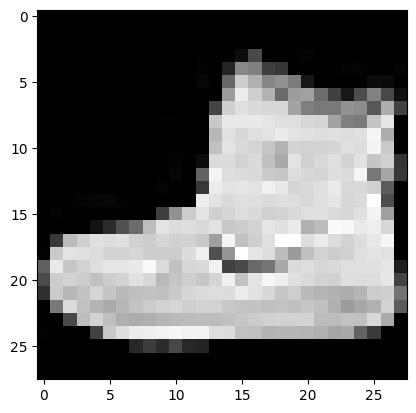

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 0, 9, 1, 3, 2, 0, 3, 9, 4, 3, 6, 9, 8, 2, 8, 0, 9, 4, 4, 2, 7, 2, 6,
        9, 3, 1, 8, 0, 2, 5, 0, 0, 7, 2, 2, 3, 8, 9, 8, 1, 5, 8, 2, 5, 3, 4, 7,
        0, 7, 9, 0, 7, 3, 4, 0, 7, 7, 9, 5, 0, 0, 0, 4, 3, 0, 0, 4, 4, 7, 2, 2,
        0, 0, 7, 5, 6, 7, 5, 5, 0, 3, 3, 7, 5, 6, 7, 5, 2, 5, 8, 9, 9, 5, 4, 4,
        5, 1, 3, 4])


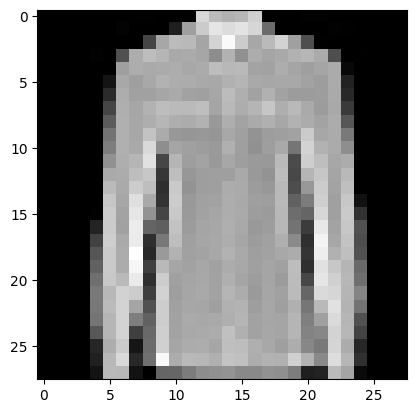

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Discriminator Network

In [8]:
image_size = 784
hidden_size = 256

In [9]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [10]:
D.to(device);

Generator Network

In [11]:
latent_size = 64

In [12]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

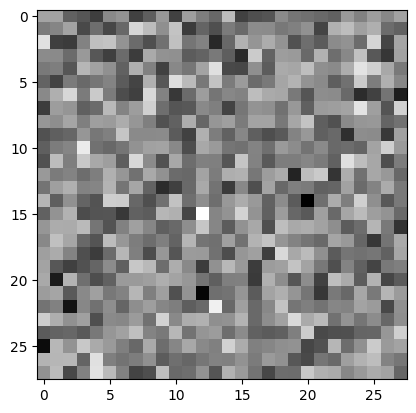

In [14]:
plt.imshow(gen_imgs[0], cmap='gray');

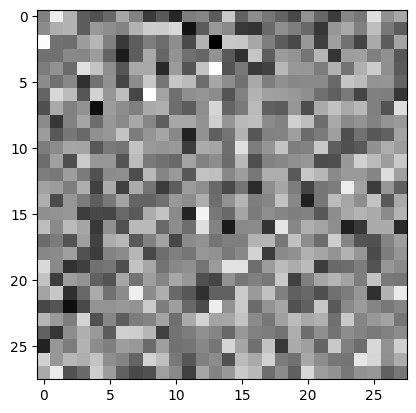

In [15]:
plt.imshow(gen_imgs[1], cmap='gray');

In [16]:
# moving the generator to the chosen device.
G.to(device);

Discriminator Training

In [17]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [18]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [19]:
def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for the real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for the fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine the losses
    d_loss = d_loss_real + d_loss_fake
    # Reset the gradients
    reset_grad()
    # Compute the gradients
    d_loss.backward()
    # Adjust the parameters using the backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0005)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [22]:
import os

# create a 'samples' directory where we can save intermediate outputs from the generator to visually inspect the progress of the model
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

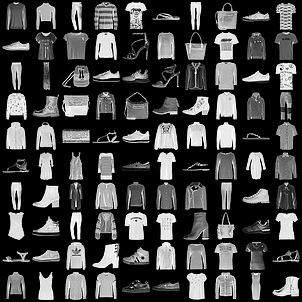

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some of the real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


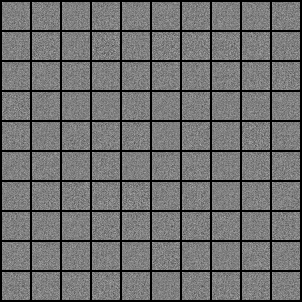

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

Step2. Train the GAN model to produce images in this new domain.

In [ ]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.1193, g_loss: 3.5634, D(x): 0.98, D(G(z)): 0.09
Epoch [0/100], Step [400/600], d_loss: 0.6185, g_loss: 1.7607, D(x): 0.82, D(G(z)): 0.30
Epoch [0/100], Step [600/600], d_loss: 0.1997, g_loss: 2.8094, D(x): 0.94, D(G(z)): 0.09
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.1290, g_loss: 3.8955, D(x): 0.96, D(G(z)): 0.05
Epoch [1/100], Step [400/600], d_loss: 0.3194, g_loss: 4.4341, D(x): 0.89, D(G(z)): 0.07
Epoch [1/100], Step [600/600], d_loss: 0.0688, g_loss: 5.5320, D(x): 0.97, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.2368, g_loss: 6.8349, D(x): 0.93, D(G(z)): 0.03
Epoch [2/100], Step [400/600], d_loss: 0.0729, g_loss: 6.1725, D(x): 0.99, D(G(z)): 0.06
Epoch [2/100], Step [600/600], d_loss: 0.2730, g_loss: 7.2599, D(x): 0.89, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.1220, g_loss: 4.9104, D(x): 0.99, D(G(z)): 0.09
Epoch [3/100], Step [400/6

Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

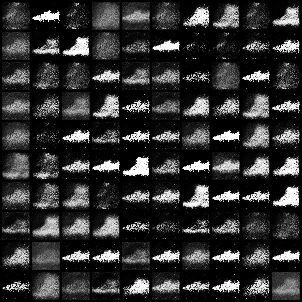

In [43]:
Image('./samples/fake_images-0010.png')

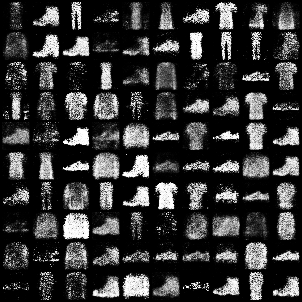

In [44]:
Image('./samples/fake_images-0050.png')

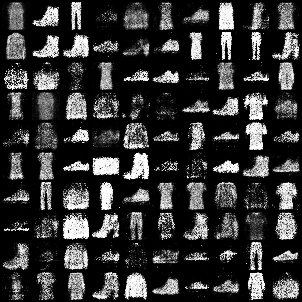

In [45]:
Image('./samples/fake_images-0080.png')

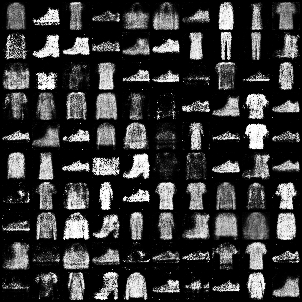

In [46]:
Image('./samples/fake_images-0100.png')

Losses of Discriminator and Generator

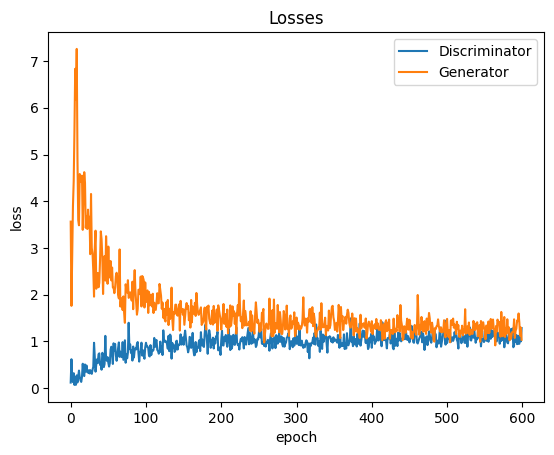

In [47]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Real Score Vs Fake Score

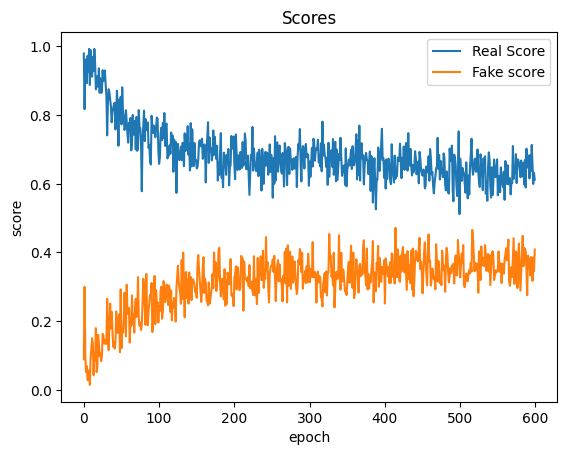

In [48]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

Step4. Save the model weights in the folder to be used later.

In [ ]:
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

Step5. Load the model using the saved weights.

In [ ]:
G.load_state_dict(torch.load('generator.pth'))
D.load_state_dict(torch.load('discriminator.pth'))

Step 6: Re-train the GAN model to see if you can improve.

In [34]:
%%time

# Define additional training parameters
num_additional_epochs = 100  # Additional epochs to train
start_epoch = 100  # Assuming previous training went up to 400 epochs
end_epoch = start_epoch + num_additional_epochs  # Calculating the end epoch

# Assuming 'data_loader' and 'batch_size' are already defined and initialized
total_step = len(data_loader)

# Loop over the additional epochs for further training
for epoch in range(start_epoch, end_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Flatten the batch of images
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, fake_images = train_generator()

        # Optionally log losses and scores at specified intervals
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{end_epoch}], Step [{i + 1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save generated images after each epoch
    save_fake_images(epoch + 1)


Epoch [100/200], Step [200/600], d_loss: 0.9496, g_loss: 1.5110, D(x): 0.66, D(G(z)): 0.31
Epoch [100/200], Step [400/600], d_loss: 1.1045, g_loss: 1.2676, D(x): 0.62, D(G(z)): 0.35
Epoch [100/200], Step [600/600], d_loss: 1.0559, g_loss: 1.4026, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0101.png
Epoch [101/200], Step [200/600], d_loss: 0.9226, g_loss: 1.3484, D(x): 0.70, D(G(z)): 0.33
Epoch [101/200], Step [400/600], d_loss: 1.2723, g_loss: 1.2488, D(x): 0.65, D(G(z)): 0.43
Epoch [101/200], Step [600/600], d_loss: 0.9185, g_loss: 1.3235, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0102.png
Epoch [102/200], Step [200/600], d_loss: 0.9135, g_loss: 1.2724, D(x): 0.72, D(G(z)): 0.34
Epoch [102/200], Step [400/600], d_loss: 1.0151, g_loss: 1.3240, D(x): 0.67, D(G(z)): 0.34
Epoch [102/200], Step [600/600], d_loss: 0.9120, g_loss: 1.4784, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0103.png
Epoch [103/200], Step [200/600], d_loss: 0.8624, g_loss: 1.9442, D(x): 0.70, D(G(z)): 0.25
Epoch 

Step 7: Save the model weights without using checkpoints.

In [35]:
torch.save(G.state_dict(), 'generator_retrained.pth')
torch.save(D.state_dict(), 'discriminator_retrained.pth')

Step 8: Load the model weights without using checkpoints.

In [36]:
G.load_state_dict(torch.load('generator_retrained.pth'))
D.load_state_dict(torch.load('discriminator_retrained.pth'))

<All keys matched successfully>

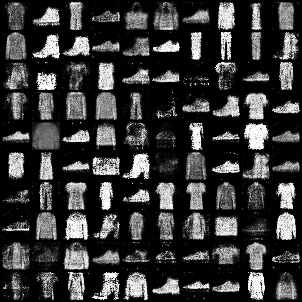

In [37]:
Image('./samples/fake_images-0105.png')

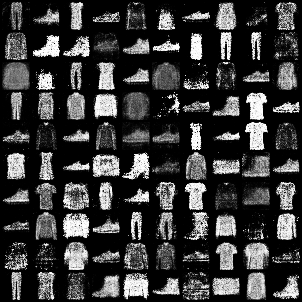

In [38]:
Image('./samples/fake_images-0150.png')

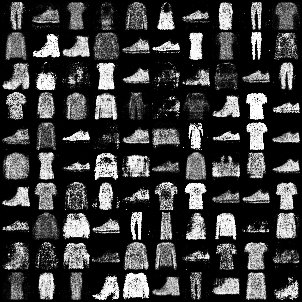

In [39]:
Image('./samples/fake_images-0175.png')

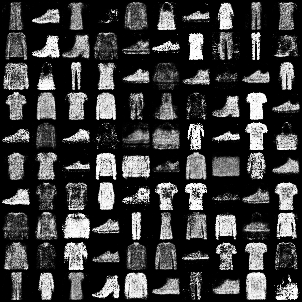

In [40]:
Image('./samples/fake_images-0200.png')

Losses of Discriminator and Generator

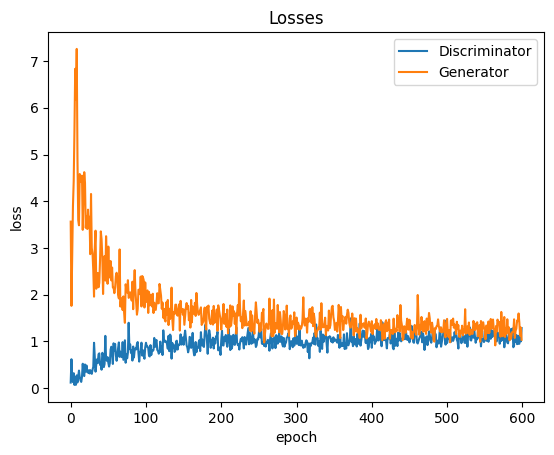

In [49]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Real Score Vs Fake Score

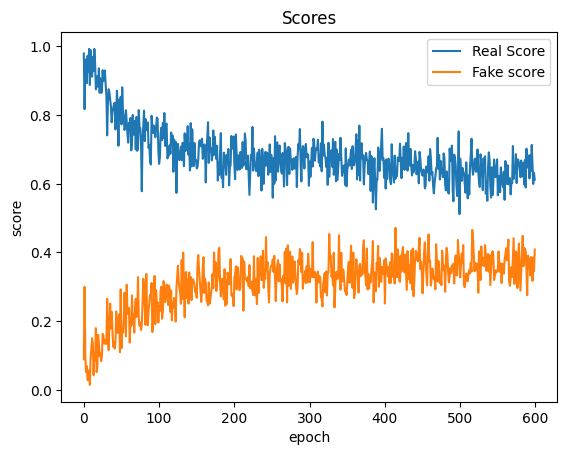

In [42]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');